First part of analysis was done in homog_s27_s27l_mesc_riboprof_0_collate_read_counts.ipynb, including collation of data into the CSV that is used here as input, graphing of read counts per region, and PCA

This notebook is adapted from /home/research/riboprof/riboprof/notebooks/S27L_voom.ipynb

In [1]:
library(limma)
library(edgeR)

In [2]:
# this file, with gene counts for each transcript (rows) in each sample (columns), 
# was generated in homog_s27_s27l_mesc_riboprof_0_collate_read_counts.ipynb
source_path = '/home/tsusanto/git/ribosome_profiling/hiND14v2/combined_file.txt'
counts = read.table(source_path, sep='\t', header=TRUE, row.names=1)
colnames(counts) =c('wt_rep1_RFP',
                    'wt_rep2_RFP',
                    'wt_rep3_RFP',
                    'Nterm_rep1_RFP',
                    'Nterm_rep2_RFP',
                    'Nterm_rep3_RFP',
                    'wt_rep1_RNA',
                    'wt_rep3_RNA',
                    'Nterm_rep2_RNA',
                    'wt_rep2_RNA',
                    'Nterm_rep3_RNA',
                    'Nterm_rep1_RNA')
head(counts)

,wt_rep1_RFP,wt_rep2_RFP,wt_rep3_RFP,Nterm_rep1_RFP,Nterm_rep2_RFP,Nterm_rep3_RFP,wt_rep1_RNA,wt_rep3_RNA,Nterm_rep2_RNA,wt_rep2_RNA,Nterm_rep3_RNA,Nterm_rep1_RNA
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENST00000297405,107,145,115,104,138,192,244,264,213,197,235,219
ENST00000446961,214,326,298,233,214,319,857,827,592,706,722,665
ENST00000377175,0,0,0,0,0,0,0,0,0,0,0,0
ENST00000336726,0,0,0,0,0,0,0,1,5,1,0,0
ENST00000342380,0,0,0,0,1,0,0,2,1,0,0,2
ENST00000259154,870,1088,805,719,753,827,1453,1469,1154,1313,1259,1117


In [3]:
# convert to gene names
mart_path = '/labs/mbarna/index/mart_homo-sapiens_geneID_transcriptID_transcriptID-v_gene-name.txt'
mart = read.table(mart_path, sep='\t', header=TRUE)
rownames(mart) = mart$Transcript.stable.ID

mart[1:10,]

,Gene.stable.ID,Transcript.stable.ID,Transcript.stable.ID.version,Gene.name
,<chr>,<chr>,<chr>,<chr>
ENST00000387314,ENSG00000210049,ENST00000387314,ENST00000387314.1,MT-TF
ENST00000389680,ENSG00000211459,ENST00000389680,ENST00000389680.2,MT-RNR1
ENST00000387342,ENSG00000210077,ENST00000387342,ENST00000387342.1,MT-TV
ENST00000387347,ENSG00000210082,ENST00000387347,ENST00000387347.2,MT-RNR2
ENST00000386347,ENSG00000209082,ENST00000386347,ENST00000386347.1,MT-TL1
ENST00000361390,ENSG00000198888,ENST00000361390,ENST00000361390.2,MT-ND1
ENST00000387365,ENSG00000210100,ENST00000387365,ENST00000387365.1,MT-TI
ENST00000387372,ENSG00000210107,ENST00000387372,ENST00000387372.1,MT-TQ
ENST00000387377,ENSG00000210112,ENST00000387377,ENST00000387377.1,MT-TM


In [4]:
name_for_tid = mart[,"Gene.name"]
names(name_for_tid) = rownames(mart)
rownames(counts) = paste(name_for_tid[rownames(counts)], rownames(counts), sep='_')
counts[1:10,]

,wt_rep1_RFP,wt_rep2_RFP,wt_rep3_RFP,Nterm_rep1_RFP,Nterm_rep2_RFP,Nterm_rep3_RFP,wt_rep1_RNA,wt_rep3_RNA,Nterm_rep2_RNA,wt_rep2_RNA,Nterm_rep3_RNA,Nterm_rep1_RNA
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CSMD3_ENST00000297405,107,145,115,104,138,192,244,264,213,197,235,219
LRRC20_ENST00000446961,214,326,298,233,214,319,857,827,592,706,722,665
OR2W1_ENST00000377175,0,0,0,0,0,0,0,0,0,0,0,0
HORMAD2_ENST00000336726,0,0,0,0,0,0,0,1,5,1,0,0
ASTL_ENST00000342380,0,0,0,0,1,0,0,2,1,0,0,2
KCTD3_ENST00000259154,870,1088,805,719,753,827,1453,1469,1154,1313,1259,1117
RBM5_ENST00000347869,3329,4273,3663,3191,3062,3752,3313,3683,2892,3239,3521,2812
PAM16_ENST00000318059,26,34,27,26,20,42,203,221,189,187,174,206
UPF3A_ENST00000375299,703,977,774,728,688,874,1417,1404,1109,1194,1064,989


In [5]:
dim(counts)

[1] 19972    12

In [6]:
# option to exclude mitochondria-encoded genes, also genes without gene names

counts = counts[-grep('^MT-*', rownames(counts)),]
counts = counts[grep('.+_', rownames(counts)),]

dim(counts)
counts[1:10,]

[1] 19280    12

,wt_rep1_RFP,wt_rep2_RFP,wt_rep3_RFP,Nterm_rep1_RFP,Nterm_rep2_RFP,Nterm_rep3_RFP,wt_rep1_RNA,wt_rep3_RNA,Nterm_rep2_RNA,wt_rep2_RNA,Nterm_rep3_RNA,Nterm_rep1_RNA
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CSMD3_ENST00000297405,107,145,115,104,138,192,244,264,213,197,235,219
LRRC20_ENST00000446961,214,326,298,233,214,319,857,827,592,706,722,665
OR2W1_ENST00000377175,0,0,0,0,0,0,0,0,0,0,0,0
HORMAD2_ENST00000336726,0,0,0,0,0,0,0,1,5,1,0,0
ASTL_ENST00000342380,0,0,0,0,1,0,0,2,1,0,0,2
KCTD3_ENST00000259154,870,1088,805,719,753,827,1453,1469,1154,1313,1259,1117
RBM5_ENST00000347869,3329,4273,3663,3191,3062,3752,3313,3683,2892,3239,3521,2812
PAM16_ENST00000318059,26,34,27,26,20,42,203,221,189,187,174,206
UPF3A_ENST00000375299,703,977,774,728,688,874,1417,1404,1109,1194,1064,989


In [7]:
# parse and assemble sample data

samples = array(data=NA, dim=c(ncol(counts), 3))
rownames(samples) = colnames(counts)
colnames(samples) = c('genotype', 'rep', 'RFP_or_RNA')

splits = strsplit(colnames(counts), '_')
for (i in 1:nrow(samples)) {
   samples[i,] = splits[[i]][1:3]
}

samples = data.frame(samples)

samples$RFP_or_RNA = factor(samples$RFP_or_RNA, levels=c('RFP', 'RNA'))
samples$genotype = factor(samples$genotype)
samples$rep = factor(substr(samples$rep, 4, 4), levels = c(1, 2, 3))
samples$grouping = paste(samples$genotype, samples$RFP_or_RNA, sep='_')

samples

,genotype,rep,RFP_or_RNA,grouping
,<fct>,<fct>,<fct>,<chr>
wt_rep1_RFP,wt,1,RFP,wt_RFP
wt_rep2_RFP,wt,2,RFP,wt_RFP
wt_rep3_RFP,wt,3,RFP,wt_RFP
Nterm_rep1_RFP,Nterm,1,RFP,Nterm_RFP
Nterm_rep2_RFP,Nterm,2,RFP,Nterm_RFP
Nterm_rep3_RFP,Nterm,3,RFP,Nterm_RFP
wt_rep1_RNA,wt,1,RNA,wt_RNA
wt_rep3_RNA,wt,3,RNA,wt_RNA
Nterm_rep2_RNA,Nterm,2,RNA,Nterm_RNA


###### analysis for RNA w/ all 6 samples

In [8]:
# first analyze only the RNA samples on their own

counts_rna = counts[,samples$RFP_or_RNA=='RNA']
samples_rna = samples[samples$RFP_or_RNA=='RNA',]
group_rna = samples_rna$grouping

data_rna = DGEList(counts = counts_rna, samples = samples_rna, group = group_rna)

data_rna

,wt_rep1_RNA,wt_rep3_RNA,Nterm_rep2_RNA,wt_rep2_RNA,Nterm_rep3_RNA,Nterm_rep1_RNA
CSMD3_ENST00000297405,244,264,213,197,235,219
LRRC20_ENST00000446961,857,827,592,706,722,665
OR2W1_ENST00000377175,0,0,0,0,0,0
HORMAD2_ENST00000336726,0,1,5,1,0,0
ASTL_ENST00000342380,0,2,1,0,0,2
KCTD3_ENST00000259154,1453,1469,1154,1313,1259,1117
RBM5_ENST00000347869,3313,3683,2892,3239,3521,2812
PAM16_ENST00000318059,203,221,189,187,174,206
UPF3A_ENST00000375299,1417,1404,1109,1194,1064,989
HLCS_ENST00000674895,899,984,651,796,744,709


In [9]:
# filter out low-expressed genes
# try min.count = 10 (gene has to be expressed above 10 counts in a 'meaningful' number of samples)
# ^^ min.count = 10 is actually the default, I believe

# I think 'meaningful' is defined by the group attribute of data_rna

# the edgeR User's Guide mentions this should be performed on normalized counts,
# but in all the examples it's done before TMM normalization...

# going to generate a cpm version of data_rna and use that for determining which genes to keep.

data_rna_cpm <- cpm(data_rna, log=FALSE)
head(data_rna_cpm)

,wt_rep1_RNA,wt_rep3_RNA,Nterm_rep2_RNA,wt_rep2_RNA,Nterm_rep3_RNA,Nterm_rep1_RNA
CSMD3_ENST00000297405,10.26434,11.06507834,11.78871110,9.48252102,11.46306,11.591779
LRRC20_ENST00000446961,36.05137,34.66219615,32.76486840,33.98304487,35.21842,35.198780
OR2W1_ENST00000377175,0.00000,0.00000000,0.00000000,0.00000000,0.00000,0.000000
HORMAD2_ENST00000336726,0.00000,0.04191318,0.27673031,0.04813462,0.00000,0.000000
ASTL_ENST00000342380,0.00000,0.08382635,0.05534606,0.00000000,0.00000,0.105861
KCTD3_ENST00000259154,61.12328,61.57045483,63.86935496,63.20076191,61.41273,59.123365


In [10]:
# generate the vector for which genes to keep

# if you don't want to use the filterByExpr function, can write your own
# criteria for which genes to keep

keep_cpm = filterByExpr(data_rna_cpm, min.count=10, group = data_rna$samples$group)
table(keep_cpm)

keep_cpm
FALSE  TRUE 
 8748 10532 

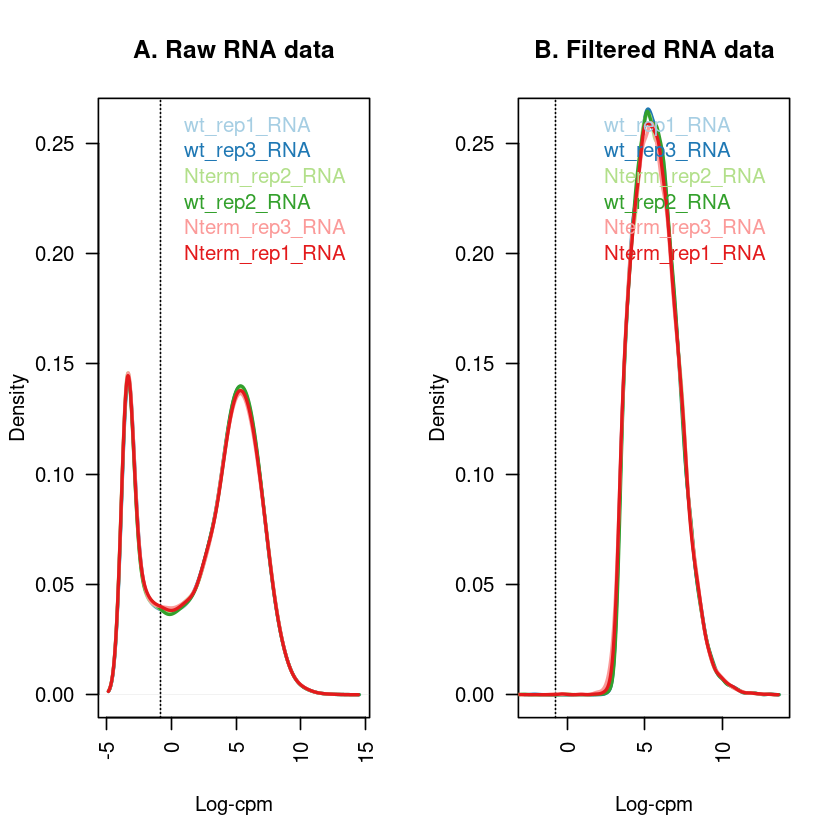

In [11]:
# plot CPM histograms to compare raw vs. filtered data

L <- mean(data_rna$samples$lib.size) * 1e-6
M <- median(data_rna$samples$lib.size) * 1e-6

lcpm.cutoff <- log2(10/M + 2/L)
library(RColorBrewer)
nsamples <- ncol(data_rna)
col <- brewer.pal(nsamples, "Paired")
par(mfrow=c(1,2))

lcpm <- cpm(data_rna, log=TRUE)

plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.26), las=2, main="", xlab="")
title(main="A. Raw RNA data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
    den <- density(lcpm[,i])
    lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", rownames(data_rna$samples), text.col=col, bty="n")


# here is where I actually filter out the low-expressed genes from data_rna
data_rna = data_rna[keep_cpm, keep.lib.sizes=FALSE]

lcpm <- cpm(data_rna, log=TRUE)

plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.26), las=2, main="", xlab="")
title(main="B. Filtered RNA data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
    den <- density(lcpm[,i])
    lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", rownames(data_rna$samples), text.col=col, bty="n")

In [12]:
# calculate normalizing factors for RNA samples

data_rna = calcNormFactors(data_rna, method='TMM')
data_rna$samples$norm.factors

[1] 0.9932048 0.9995015 1.0052312 0.9986071 1.0015296 1.0019668

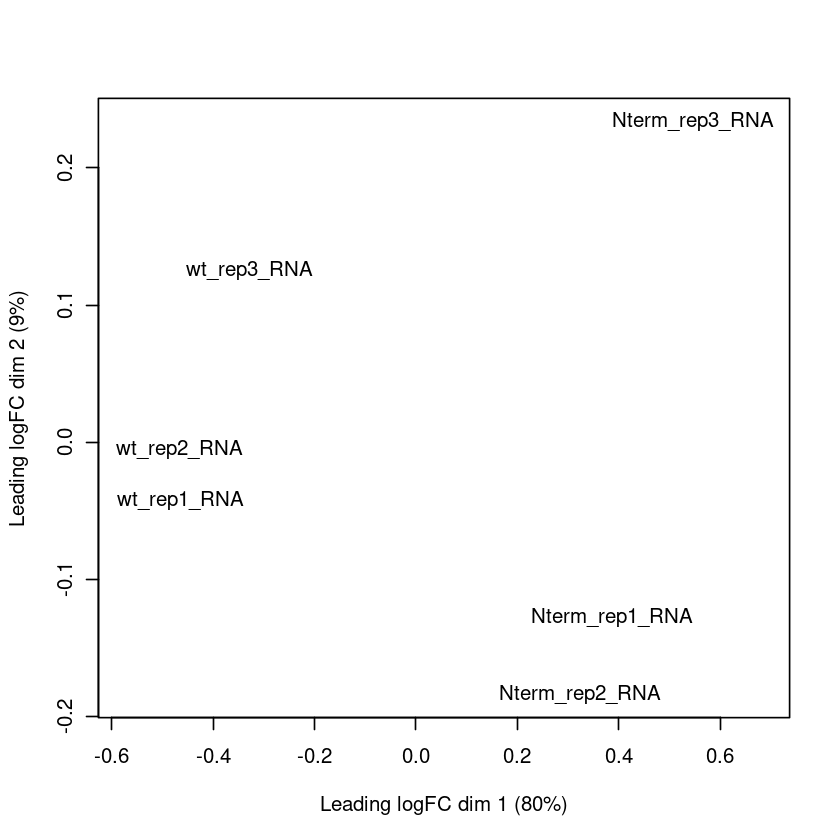

In [13]:
# plot multidimensional scaling -- an unsupervised look at the biggest
# differences between samples

lcpm = cpm(data_rna, log=TRUE)
plotMDS(lcpm, labels=rownames(data_rna$samples))

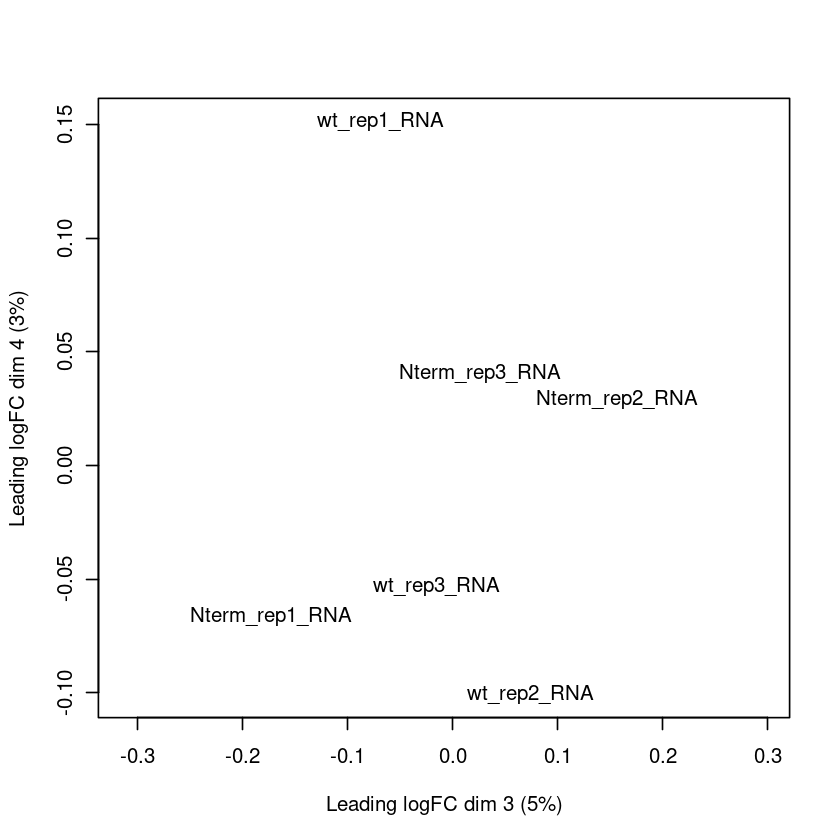

In [14]:
plotMDS(lcpm, labels=rownames(data_rna$samples), dim.plot=c(3,4))

In [15]:
data_rna$samples

,group,lib.size,norm.factors,genotype,rep,RFP_or_RNA,grouping
,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<chr>
wt_rep1_RNA,wt_RNA,23422716,0.9932048,wt,1,RNA,wt_RNA
wt_rep3_RNA,wt_RNA,23513589,0.9995015,wt,3,RNA,wt_RNA
Nterm_rep2_RNA,Nterm_RNA,17810659,1.0052312,Nterm,2,RNA,Nterm_RNA
wt_rep2_RNA,wt_RNA,20464671,0.9986071,wt,2,RNA,wt_RNA
Nterm_rep3_RNA,Nterm_RNA,20221169,1.0015296,Nterm,3,RNA,Nterm_RNA
Nterm_rep1_RNA,Nterm_RNA,18631017,1.0019668,Nterm,1,RNA,Nterm_RNA


In [16]:
line = data_rna$samples$genotype

# this design matrix is fairly simple. we intend to compare by 'line', and lane' is included as batch variable
design_rna = model.matrix(~0+line, data=data_rna$samples)
colnames(design_rna) = gsub('>', '_to_', colnames(design_rna))

design_rna

,lineNterm,linewt
wt_rep1_RNA,0,1
wt_rep3_RNA,0,1
Nterm_rep2_RNA,1,0
wt_rep2_RNA,0,1
Nterm_rep3_RNA,1,0
Nterm_rep1_RNA,1,0


In [17]:
# make contrasts

rna_de = makeContrasts(linewt - lineNterm,
                       levels=colnames(design_rna))

rna_de

,linewt - lineNterm
lineNterm,-1
linewt,1


An object of class "EList"
$targets
                   group lib.size norm.factors genotype rep RFP_or_RNA
wt_rep1_RNA       wt_RNA 23263554    0.9932048       wt   1        RNA
wt_rep3_RNA       wt_RNA 23501868    0.9995015       wt   3        RNA
Nterm_rep2_RNA Nterm_RNA 17903830    1.0052312    Nterm   2        RNA
wt_rep2_RNA       wt_RNA 20436167    0.9986071       wt   2        RNA
Nterm_rep3_RNA Nterm_RNA 20252099    1.0015296    Nterm   3        RNA
Nterm_rep1_RNA Nterm_RNA 18667660    1.0019668    Nterm   1        RNA
                grouping
wt_rep1_RNA       wt_RNA
wt_rep3_RNA       wt_RNA
Nterm_rep2_RNA Nterm_RNA
wt_rep2_RNA       wt_RNA
Nterm_rep3_RNA Nterm_RNA
Nterm_rep1_RNA Nterm_RNA

$E
                       wt_rep1_RNA wt_rep3_RNA Nterm_rep2_RNA wt_rep2_RNA
CSMD3_ENST00000297405     3.393691    3.492420       3.575896    3.272656
LRRC20_ENST00000446961    5.203993    5.137912       5.048475    5.111493
KCTD3_ENST00000259154     5.965316    5.966406       6.010856    6.006148
RBM5_ENST00000347869      7.154141    7.292158       7.335905    7.308503
UPF3A_ENST00000375299     5.929133    5.901137       5.953498    5.869138
                       Nterm_rep3_RNA Nterm_rep1_RNA
CSMD3_ENST00000297405        3.539584       3.555608
LRRC20_ENST00000446961       5.156854       5.155826
KCTD3_ENST00000259154        5.958636       5.903590
RBM5_ENST00000347869         7.441975       7.235168
UPF3A_ENST00000375299        5.715961       5.728087
10527 more rows ...

$weights
          [,1]     [,2]      [,3]      [,4]      [,5]      [,6]
[1,]  64.38779  64.8918  57.75582  58.36247  63.40042  59.60057
[2,] 173.75823 175.1409 137.19692 156.39220 152.36775 142.14129
[3,] 255.74154 257.2039 215.31483 237.08850 233.65376 221.52164
[4,] 358.90198 359.7179 339.26638 347.25047 352.10698 343.93602
[5,] 248.01364 249.4210 199.54370 228.92967 217.29817 205.48557
10527 more rows ...

$design
               lineNterm linewt
wt_rep1_RNA            0      1
wt_rep3_RNA            0      1
Nterm_rep2_RNA         1      0
wt_rep2_RNA            0      1
Nterm_rep3_RNA         1      0
Nterm_rep1_RNA         1      0
attr(,"assign")
[1] 1 1
attr(,"contrasts")
attr(,"contrasts")$line
[1] "contr.treatment"

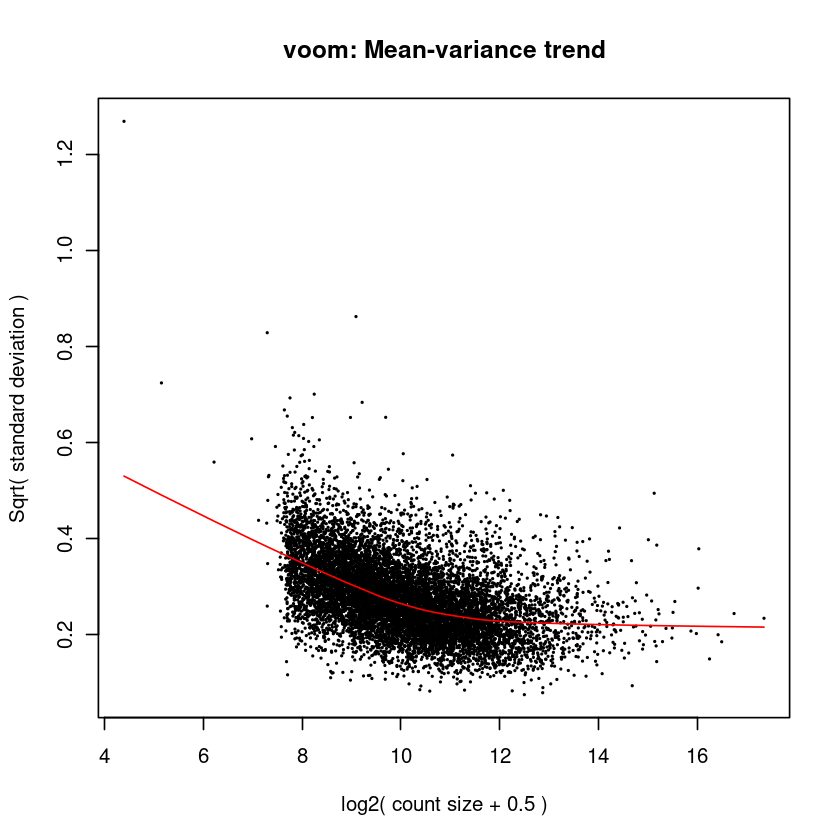

In [18]:
# perform voom

v_rna = voom(data_rna, design_rna, plot=TRUE)
v_rna

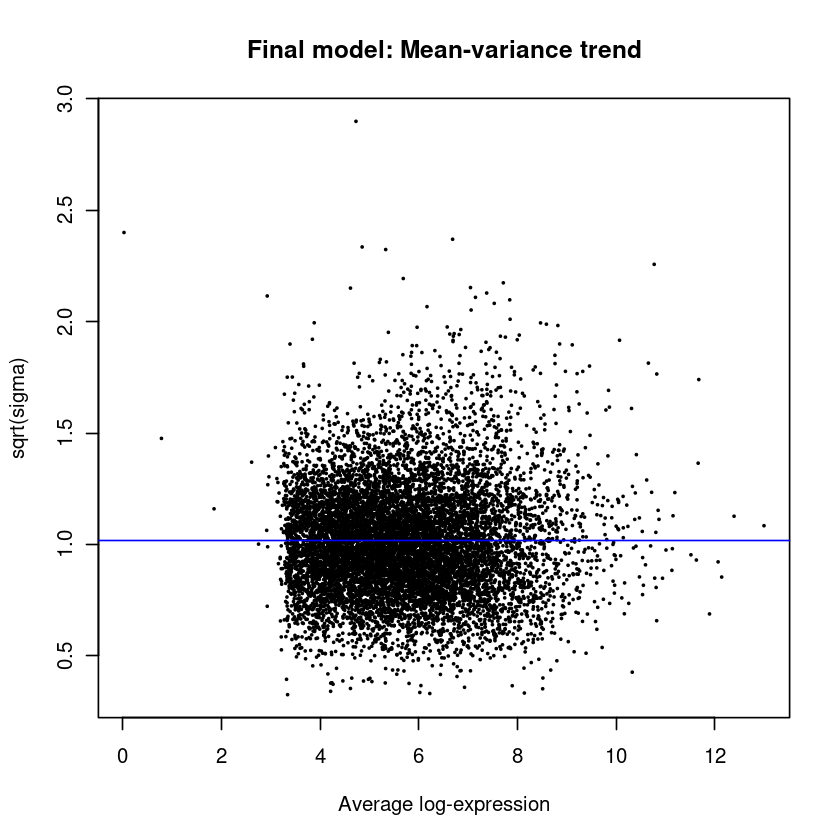

In [19]:
# run the linear model

v_rna_fit = lmFit(v_rna, design_rna)
v_rna_fit = contrasts.fit(v_rna_fit, contrasts=rna_de)
e_rna_fit = eBayes(v_rna_fit)
plotSA(e_rna_fit, main='Final model: Mean-variance trend')

In [20]:
# test for any significantly diff expr genes

dt_rna = decideTests(e_rna_fit, p.value=0.1)
summary(dt_rna)

       linewt - lineNterm
Down                 1425
NotSig               7257
Up                   1850

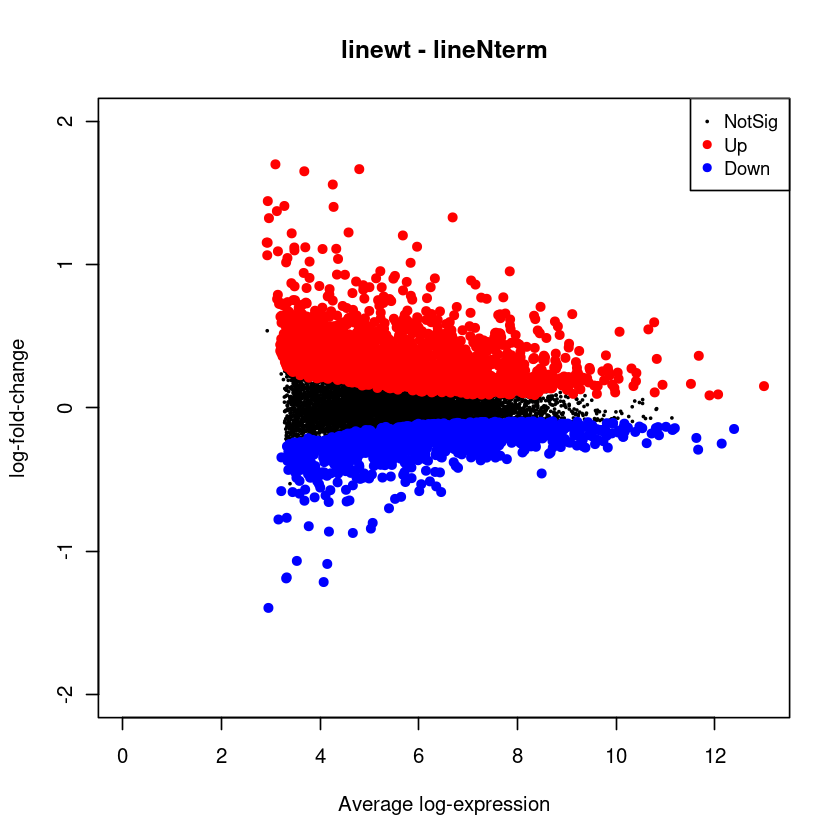

In [21]:
# plots for mean expr vs logFC

plotMD(e_rna_fit, 
       column=1, 
       status=dt_rna[,1], 
       main=colnames(e_rna_fit)[1],
       ylim=c(-2,2))

In [22]:
# generate a table of all kept genes as ranked by p-value
ranked_genes = topTable(e_rna_fit, coef=1, number=sum(keep_cpm), sort.by='p')
ranked_genes

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PCDHA10_ENST00000307360,6.0612396,2.75513082,35.573767,3.524489e-13,3.711992e-09,12.484988
TCEAL5_ENST00000372680,-7.4940170,0.78776889,-28.504399,4.449570e-12,2.343144e-08,11.674537
TRIM58_ENST00000366481,4.6647911,1.85326181,23.502533,4.001840e-11,1.404913e-07,11.019253
ELAPOR2_ENST00000450689,1.0129912,5.83525382,19.297955,3.710842e-10,9.770648e-07,13.813677
ZNF471_ENST00000308031,1.5591344,4.25837381,18.351125,6.528052e-10,1.375069e-06,12.661004
MXRA8_ENST00000309212,1.4030422,4.27491675,13.841694,1.491351e-08,2.617818e-05,10.054379
PAAF1_ENST00000310571,0.7775254,5.28930061,13.550330,1.882334e-08,2.832106e-05,10.023874
ZNF667_ENST00000504904,7.8201712,0.02913001,12.881395,3.268604e-08,4.236505e-05,7.825147
ZNF506_ENST00000540806,1.0398821,4.36503991,12.760785,3.620257e-08,4.236505e-05,9.287652


In [23]:
library(ggplot2)

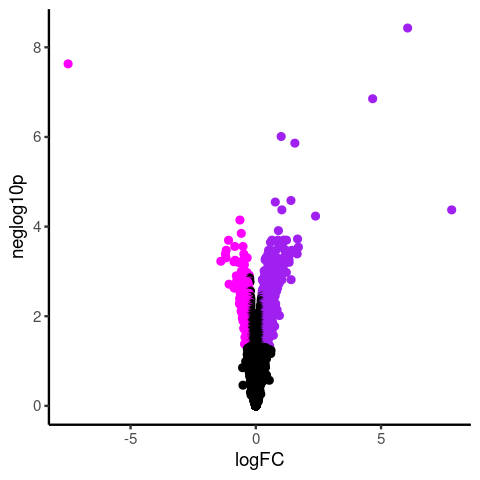

In [24]:
ranked_genes$neglog10p = -log(ranked_genes$adj.P.Val, 10)
ranked_genes$plot_fill = rep('black', nrow(ranked_genes))
ranked_genes[ranked_genes$logFC > 0.25 & ranked_genes$adj.P.Val < 0.05,'plot_fill'] = 'purple'
ranked_genes[ranked_genes$logFC < -0.25 & ranked_genes$adj.P.Val < 0.05,'plot_fill'] = 'magenta'

pal = c('black', 'magenta', 'purple')

ranked_genes$plot_fill = factor(ranked_genes$plot_fill, levels = pal)

options(repr.plot.width=4, repr.plot.height=4)

ggplot(data=ranked_genes, aes(x=logFC, y=neglog10p, color=plot_fill)) + geom_point() + scale_color_manual(values=pal) + theme_classic() + theme(legend.position='none')


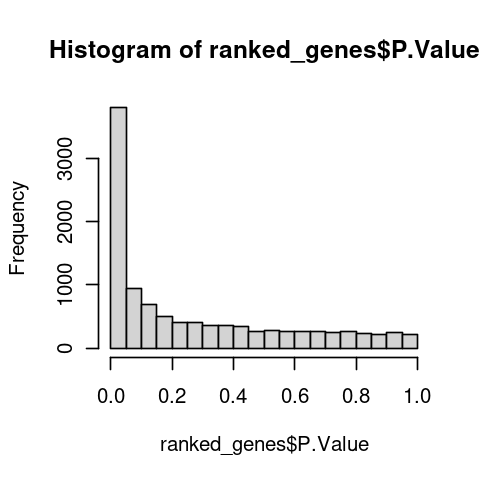

In [25]:
# check distribution of p-values
hist(ranked_genes$P.Value)

In [26]:
# spot check CPM values for some genes to see if the p-values are reasonable...
data_rna_cpm[c('TSTD2_ENST00000341170',
              'KLHL36_ENST00000564996',
              'PARN_ENST00000437198'),]

,wt_rep1_RNA,wt_rep3_RNA,Nterm_rep2_RNA,wt_rep2_RNA,Nterm_rep3_RNA,Nterm_rep1_RNA
TSTD2_ENST00000341170,61.41774,59.09758,63.86935,59.20559,66.24185,60.18198
KLHL36_ENST00000564996,97.17465,93.84360,83.51721,94.82521,87.70460,87.17653
PARN_ENST00000437198,41.81455,42.20657,39.01897,45.05401,39.02318,39.38029


###### analysis for RFP w/ all 6 samples

In [58]:
# only the RPF samples on their own

counts_rfp = counts[,samples$RFP_or_RNA=='RFP']
samples_rfp = samples[samples$RFP_or_RNA=='RFP',]
group_rfp = samples_rfp$grouping

data_rfp = DGEList(counts = counts_rfp, samples = samples_rfp, group = group_rfp)

data_rfp

,wt_rep1_RFP,wt_rep2_RFP,wt_rep3_RFP,Nterm_rep1_RFP,Nterm_rep2_RFP,Nterm_rep3_RFP
CSMD3_ENST00000297405,107,145,115,104,138,192
LRRC20_ENST00000446961,214,326,298,233,214,319
OR2W1_ENST00000377175,0,0,0,0,0,0
HORMAD2_ENST00000336726,0,0,0,0,0,0
ASTL_ENST00000342380,0,0,0,0,1,0
KCTD3_ENST00000259154,870,1088,805,719,753,827
RBM5_ENST00000347869,3329,4273,3663,3191,3062,3752
PAM16_ENST00000318059,26,34,27,26,20,42
UPF3A_ENST00000375299,703,977,774,728,688,874
HLCS_ENST00000674895,508,625,510,475,442,555


In [59]:
# filter out low-expressed genes
# try min.count = 10 (gene has to be expressed above 10 counts in a 'meaningful' number of samples)
# ^^ min.count = 10 is actually the default, I believe

# I think 'meaningful' is defined by the group attribute of data_rna

# the edgeR User's Guide mentions this should be performed on normalized counts,
# but in all the examples it's done before TMM normalization...

# going to generate a cpm version of data_rna and use that for determining which genes to keep.

data_rfp_cpm <- cpm(data_rfp, log=FALSE)
head(data_rfp_cpm)

,wt_rep1_RFP,wt_rep2_RFP,wt_rep3_RFP,Nterm_rep1_RFP,Nterm_rep2_RFP,Nterm_rep3_RFP
CSMD3_ENST00000297405,8.193945,8.926056,8.292723,8.268704,10.58530200,12.73809
LRRC20_ENST00000446961,16.387890,20.068236,21.488969,18.525078,16.41488861,21.16380
OR2W1_ENST00000377175,0.000000,0.000000,0.000000,0.000000,0.00000000,0.00000
HORMAD2_ENST00000336726,0.000000,0.000000,0.000000,0.000000,0.00000000,0.00000
ASTL_ENST00000342380,0.000000,0.000000,0.000000,0.000000,0.07670509,0.00000
KCTD3_ENST00000259154,66.623665,66.976198,58.049061,57.165369,57.75893049,54.86666


In [60]:
# generate the vector for which genes to keep

# if you don't want to use the filterByExpr function, can write your own
# criteria for which genes to keep

keep_cpm = filterByExpr(data_rfp_cpm, min.count=10, group = data_rfp$samples$group)
table(keep_cpm)

keep_cpm
FALSE  TRUE 
 9031 10249 

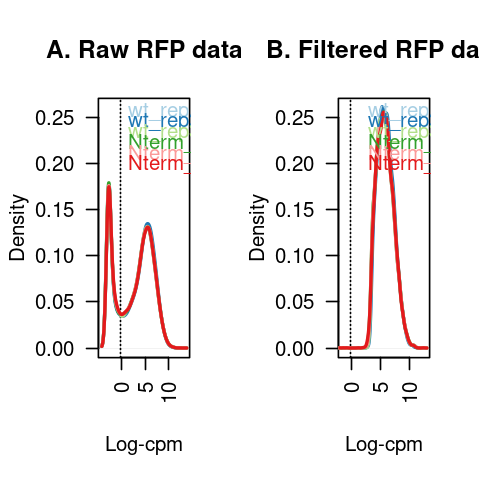

In [61]:
# plot CPM histograms to compare raw vs. filtered data

L <- mean(data_rfp$samples$lib.size) * 1e-6
M <- median(data_rfp$samples$lib.size) * 1e-6

lcpm.cutoff <- log2(10/M + 2/L)
library(RColorBrewer)
nsamples <- ncol(data_rfp)
col <- brewer.pal(nsamples, "Paired")
par(mfrow=c(1,2))

lcpm <- cpm(data_rfp, log=TRUE)

plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.26), las=2, main="", xlab="")
title(main="A. Raw RFP data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
    den <- density(lcpm[,i])
    lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", rownames(data_rfp$samples), text.col=col, bty="n")


# here is where I actually filter out the low-expressed genes from data_rfp
data_rfp = data_rfp[keep_cpm, keep.lib.sizes=FALSE]

lcpm <- cpm(data_rfp, log=TRUE)

plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.26), las=2, main="", xlab="")
title(main="B. Filtered RFP data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
    den <- density(lcpm[,i])
    lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", rownames(data_rfp$samples), text.col=col, bty="n")

In [62]:
# calculate normalizing factors for RNA samples

data_rfp = calcNormFactors(data_rfp, method='TMM')
data_rfp$samples$norm.factors

[1] 0.9939021 1.0363717 0.9906528 0.9908011 0.9833805 1.0057993

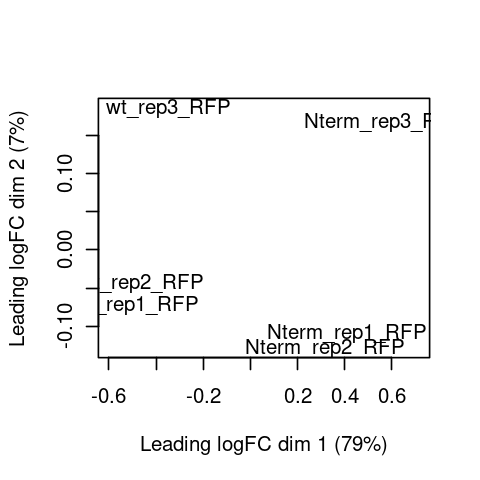

In [63]:
# plot multidimensional scaling -- an unsupervised look at the biggest
# differences between samples

lcpm = cpm(data_rfp, log=TRUE)
plotMDS(lcpm, labels=rownames(data_rfp$samples))

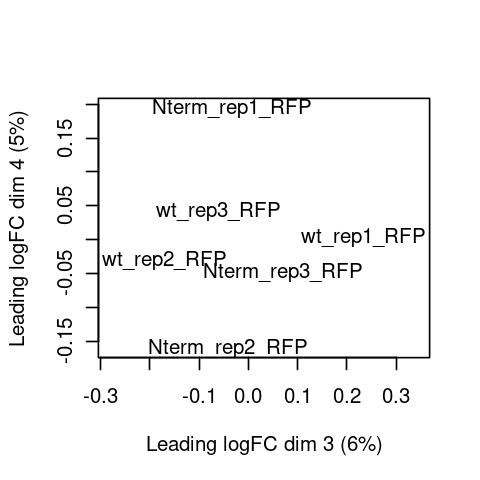

In [64]:
plotMDS(lcpm, labels=rownames(data_rfp$samples), dim.plot=c(3,4))

In [65]:
data_rfp$samples

,group,lib.size,norm.factors,genotype,rep,RFP_or_RNA,grouping
,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<chr>
wt_rep1_RFP,wt_RFP,12876394,0.9939021,wt,1,RFP,wt_RFP
wt_rep2_RFP,wt_RFP,16001089,1.0363717,wt,2,RFP,wt_RFP
wt_rep3_RFP,wt_RFP,13678007,0.9906528,wt,3,RFP,wt_RFP
Nterm_rep1_RFP,Nterm_RFP,12414970,0.9908011,Nterm,1,RFP,Nterm_RFP
Nterm_rep2_RFP,Nterm_RFP,12865627,0.9833805,Nterm,2,RFP,Nterm_RFP
Nterm_rep3_RFP,Nterm_RFP,14873730,1.0057993,Nterm,3,RFP,Nterm_RFP


In [66]:
line = data_rfp$samples$genotype

# this design matrix is fairly simple. we intend to compare by 'line', and lane' is included as batch variable
design_rfp = model.matrix(~0+line, data=data_rfp$samples)
colnames(design_rfp) = gsub('>', '_to_', colnames(design_rfp))

design_rfp

,lineNterm,linewt
wt_rep1_RFP,0,1
wt_rep2_RFP,0,1
wt_rep3_RFP,0,1
Nterm_rep1_RFP,1,0
Nterm_rep2_RFP,1,0
Nterm_rep3_RFP,1,0


In [67]:
# make contrasts

rfp_de = makeContrasts(linewt - lineNterm,
                       levels=colnames(design_rfp))

rfp_de

,linewt - lineNterm
lineNterm,-1
linewt,1


An object of class "EList"
$targets
                   group lib.size norm.factors genotype rep RFP_or_RNA
wt_rep1_RFP       wt_RFP 12797875    0.9939021       wt   1        RFP
wt_rep2_RFP       wt_RFP 16583076    1.0363717       wt   2        RFP
wt_rep3_RFP       wt_RFP 13550155    0.9906528       wt   3        RFP
Nterm_rep1_RFP Nterm_RFP 12300766    0.9908011    Nterm   1        RFP
Nterm_rep2_RFP Nterm_RFP 12651807    0.9833805    Nterm   2        RFP
Nterm_rep3_RFP Nterm_RFP 14959987    1.0057993    Nterm   3        RFP
                grouping
wt_rep1_RFP       wt_RFP
wt_rep2_RFP       wt_RFP
wt_rep3_RFP       wt_RFP
Nterm_rep1_RFP Nterm_RFP
Nterm_rep2_RFP Nterm_RFP
Nterm_rep3_RFP Nterm_RFP

$E
                       wt_rep1_RFP wt_rep2_RFP wt_rep3_RFP Nterm_rep1_RFP
LRRC20_ENST00000446961    4.067001    4.299299    4.461350       4.246602
KCTD3_ENST00000259154     6.087868    6.036486    5.893503       5.870175
RBM5_ENST00000347869      8.023257    8.009563    8.078769       8.019343
UPF3A_ENST00000375299     5.780574    5.881313    5.836884       5.888109
HLCS_ENST00000674895      5.312271    5.237226    5.235530       5.272625
                       Nterm_rep2_RFP Nterm_rep3_RFP
LRRC20_ENST00000446961       4.083562       4.416635
KCTD3_ENST00000259154        5.896192       5.789578
RBM5_ENST00000347869         7.919222       7.970599
UPF3A_ENST00000375299        5.766041       5.869277
HLCS_ENST00000674895         5.128262       5.214606
10244 more rows ...

$weights
          [,1]      [,2]      [,3]      [,4]      [,5]      [,6]
[1,]  64.51350  76.37103  66.95214  62.13015  63.26871  70.54946
[2,] 127.61427 141.15271 130.57302 119.99215 121.45903 130.16798
[3,] 165.28328 159.04590 164.10658 166.64150 166.21533 162.94085
[4,] 121.36815 134.86644 124.36496 119.60423 121.06518 129.77648
[5,]  98.81772 113.86333 102.04602  94.51197  96.04439 105.53156
10244 more rows ...

$design
               lineNterm linewt
wt_rep1_RFP            0      1
wt_rep2_RFP            0      1
wt_rep3_RFP            0      1
Nterm_rep1_RFP         1      0
Nterm_rep2_RFP         1      0
Nterm_rep3_RFP         1      0
attr(,"assign")
[1] 1 1
attr(,"contrasts")
attr(,"contrasts")$line
[1] "contr.treatment"

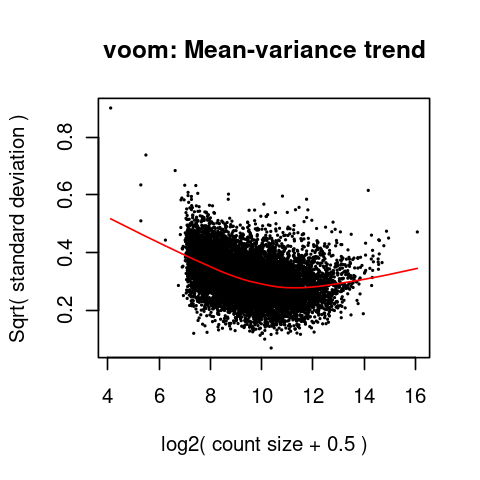

In [68]:
# perform voom

v_rfp = voom(data_rfp, design_rfp, plot=TRUE)
v_rfp

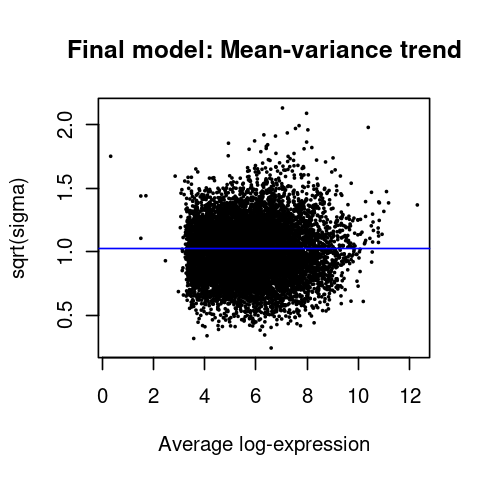

In [69]:
# run the linear model

v_rfp_fit = lmFit(v_rfp, design_rfp)
v_rfp_fit = contrasts.fit(v_rfp_fit, contrasts=rfp_de)
e_rfp_fit = eBayes(v_rfp_fit)
plotSA(e_rfp_fit, main='Final model: Mean-variance trend')

In [70]:
# test for any significantly diff expr genes

dt_rfp = decideTests(e_rfp_fit, p.value=0.1)
summary(dt_rfp)

       linewt - lineNterm
Down                  746
NotSig               8279
Up                   1224

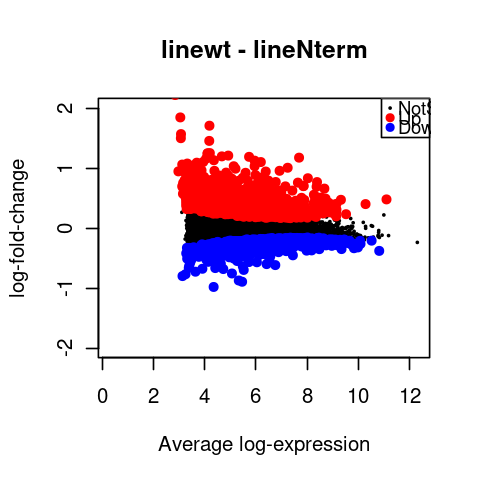

In [71]:
# plots for mean expr vs logFC

plotMD(e_rfp_fit, 
       column=1, 
       status=dt_rfp[,1], 
       main=colnames(e_rfp_fit)[1],
       ylim=c(-2,2))

In [73]:
# generate a table of all kept genes as ranked by p-value
ranked_genes = topTable(e_rfp_fit, coef=1, number=sum(keep_cpm), sort.by='p')
ranked_genes

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PCDHA10_ENST00000307360,6.7114554,2.4665105,40.529418,2.321928e-19,2.379744e-15,24.728572
GPR50_ENST00000218316,-5.7163086,1.5072131,-30.806183,3.263067e-17,1.672159e-13,22.611366
TCEAL5_ENST00000372680,-6.7013720,1.5058223,-29.892220,5.601798e-17,1.913761e-13,22.570153
PCDHB5_ENST00000231134,5.9602040,1.7046049,26.491405,4.860408e-16,1.245358e-12,21.598177
ZNF667_ENST00000504904,7.5092786,0.3290008,25.693168,8.385978e-16,1.718958e-12,21.143596
SELENOP_ENST00000514985,1.8429705,3.0481841,11.995807,4.194863e-10,6.165514e-07,13.086293
SDHAF4_ENST00000370474,1.2485256,4.2006928,11.992985,4.211006e-10,6.165514e-07,13.367151
PCDHB16_ENST00000609684,0.7865101,6.3077655,11.643132,6.816498e-10,8.732786e-07,12.950633
GBP2_ENST00000370466,1.4516611,4.1779548,10.846248,2.131682e-09,2.054950e-06,11.815448


###### analyze differential TE for all 6 samples

In [27]:
# create a DGE data object for all RNA and RPF samples

data_all = DGEList(counts = counts, samples = samples, group = samples$grouping)

data_all

,wt_rep1_RFP,wt_rep2_RFP,wt_rep3_RFP,Nterm_rep1_RFP,Nterm_rep2_RFP,Nterm_rep3_RFP,wt_rep1_RNA,wt_rep3_RNA,Nterm_rep2_RNA,wt_rep2_RNA,Nterm_rep3_RNA,Nterm_rep1_RNA
CSMD3_ENST00000297405,107,145,115,104,138,192,244,264,213,197,235,219
LRRC20_ENST00000446961,214,326,298,233,214,319,857,827,592,706,722,665
OR2W1_ENST00000377175,0,0,0,0,0,0,0,0,0,0,0,0
HORMAD2_ENST00000336726,0,0,0,0,0,0,0,1,5,1,0,0
ASTL_ENST00000342380,0,0,0,0,1,0,0,2,1,0,0,2
KCTD3_ENST00000259154,870,1088,805,719,753,827,1453,1469,1154,1313,1259,1117
RBM5_ENST00000347869,3329,4273,3663,3191,3062,3752,3313,3683,2892,3239,3521,2812
PAM16_ENST00000318059,26,34,27,26,20,42,203,221,189,187,174,206
UPF3A_ENST00000375299,703,977,774,728,688,874,1417,1404,1109,1194,1064,989
HLCS_ENST00000674895,508,625,510,475,442,555,899,984,651,796,744,709


In [28]:
# filter out low-expressed genes

# when calculating TE, Gerald filters by genes that are expressed at CPM > 1 in at least a min
# number of RPF libraries, b/c his RPF libraries have fewer reads...my RPF and RNA libraries are
# pretty similar in size...

# try min.count = 10 (gene has to be expressed above 10 counts in a 'meaningful' number of samples)
# ^^ min.count = 10 is actually the default, I believe

# I think 'meaningful' is defined by the group attribute of data_rna

# the edgeR User's Guide mentions this should be performed on normalized counts,
# but in all the examples it's done before TMM normalization...

# going to generate a cpm version of data_rna and use that for determining which genes to keep.

data_all_cpm <- cpm(data_all, log=FALSE)
head(data_all_cpm)

,wt_rep1_RFP,wt_rep2_RFP,wt_rep3_RFP,Nterm_rep1_RFP,Nterm_rep2_RFP,Nterm_rep3_RFP,wt_rep1_RNA,wt_rep3_RNA,Nterm_rep2_RNA,wt_rep2_RNA,Nterm_rep3_RNA,Nterm_rep1_RNA
CSMD3_ENST00000297405,8.193945,8.926056,8.292723,8.268704,10.58530200,12.73809,10.26434,11.06507834,11.78871110,9.48252102,11.46306,11.591779
LRRC20_ENST00000446961,16.387890,20.068236,21.488969,18.525078,16.41488861,21.16380,36.05137,34.66219615,32.76486840,33.98304487,35.21842,35.198780
OR2W1_ENST00000377175,0.000000,0.000000,0.000000,0.000000,0.00000000,0.00000,0.00000,0.00000000,0.00000000,0.00000000,0.00000,0.000000
HORMAD2_ENST00000336726,0.000000,0.000000,0.000000,0.000000,0.00000000,0.00000,0.00000,0.04191318,0.27673031,0.04813462,0.00000,0.000000
ASTL_ENST00000342380,0.000000,0.000000,0.000000,0.000000,0.07670509,0.00000,0.00000,0.08382635,0.05534606,0.00000000,0.00000,0.105861
KCTD3_ENST00000259154,66.623665,66.976198,58.049061,57.165369,57.75893049,54.86666,61.12328,61.57045483,63.86935496,63.20076191,61.41273,59.123365


In [29]:
# generate the vector for which genes to keep

keep_all_cpm = filterByExpr(data_all_cpm, min.count=10, data_all$samples$group)
table(keep_all_cpm)

keep_all_cpm
FALSE  TRUE 
 8406 10874 

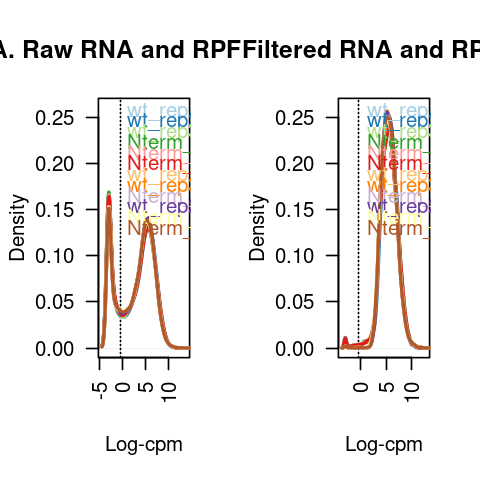

In [30]:
# plot CPM histograms to compare raw vs. filtered data

L <- mean(data_all$samples$lib.size) * 1e-6
M <- median(data_all$samples$lib.size) * 1e-6

lcpm.cutoff <- log2(10/M + 2/L)
library(RColorBrewer)
nsamples <- ncol(data_all)
col <- brewer.pal(nsamples, "Paired")
par(mfrow=c(1,2))

lcpm <- cpm(data_all, log=TRUE)

plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.26), las=2, main="", xlab="")
title(main="A. Raw RNA and RPF data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
    den <- density(lcpm[,i])
    lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", rownames(data_all$samples), text.col=col, bty="n")


# here is where I actually filter out the low-expressed genes from data_all
data_all = data_all[keep_all_cpm, keep.lib.sizes=FALSE]

lcpm <- cpm(data_all, log=TRUE)

plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.26), las=2, main="", xlab="")
title(main="B. Filtered RNA and RPF data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
    den <- density(lcpm[,i])
    lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", rownames(data_all$samples), text.col=col, bty="n")

In [31]:
# make subsets of data_all for just the RNA and ribo samples, so I can run TMM normalization on them separately.

data_rna_for_tmm = data_all[,samples$RFP_or_RNA=='RNA']
data_rpf_for_tmm = data_all[,samples$RFP_or_RNA=='RFP']

data_rna_for_tmm
data_rpf_for_tmm

,wt_rep1_RNA,wt_rep3_RNA,Nterm_rep2_RNA,wt_rep2_RNA,Nterm_rep3_RNA,Nterm_rep1_RNA
CSMD3_ENST00000297405,244,264,213,197,235,219
LRRC20_ENST00000446961,857,827,592,706,722,665
KCTD3_ENST00000259154,1453,1469,1154,1313,1259,1117
RBM5_ENST00000347869,3313,3683,2892,3239,3521,2812
UPF3A_ENST00000375299,1417,1404,1109,1194,1064,989
HLCS_ENST00000674895,899,984,651,796,744,709
YES1_ENST00000314574,1511,1513,1038,1418,941,983
ERCC1_ENST00000300853,794,832,611,728,689,647
AKAP17A_ENST00000313871,1187,1166,892,1076,962,917
LRCH4_ENST00000310300,866,924,631,733,621,660


,wt_rep1_RFP,wt_rep2_RFP,wt_rep3_RFP,Nterm_rep1_RFP,Nterm_rep2_RFP,Nterm_rep3_RFP
CSMD3_ENST00000297405,107,145,115,104,138,192
LRRC20_ENST00000446961,214,326,298,233,214,319
KCTD3_ENST00000259154,870,1088,805,719,753,827
RBM5_ENST00000347869,3329,4273,3663,3191,3062,3752
UPF3A_ENST00000375299,703,977,774,728,688,874
HLCS_ENST00000674895,508,625,510,475,442,555
YES1_ENST00000314574,738,918,654,534,584,610
ERCC1_ENST00000300853,447,642,513,474,411,527
AKAP17A_ENST00000313871,0,0,0,0,0,0
LRCH4_ENST00000310300,441,657,535,435,450,505


In [32]:
data_rna_for_tmm = calcNormFactors(data_rna_for_tmm, method='TMM')
data_rna_for_tmm$samples$norm.factors

data_rpf_for_tmm = calcNormFactors(data_rpf_for_tmm, method='TMM')
data_rpf_for_tmm$samples$norm.factors

[1] 0.9937261 0.9995795 1.0050132 0.9987464 1.0010055 1.0019649

[1] 0.9942431 1.0266094 0.9896870 0.9946378 0.9874415 1.0079245

In [33]:
# recombine the separately calculated normalization factors into data_all
data_all$samples$norm.factors[samples$RFP_or_RNA=='RNA'] = data_rna_for_tmm$samples$norm.factors
data_all$samples$norm.factors[samples$RFP_or_RNA=='RFP'] = data_rpf_for_tmm$samples$norm.factors
data_all$samples$norm.factors

[1] 0.9942431 1.0266094 0.9896870 0.9946378 0.9874415 1.0079245 0.9937261
 [8] 0.9995795 1.0050132 0.9987464 1.0010055 1.0019649

In [54]:
# Set TE
data_all_te <- data_all

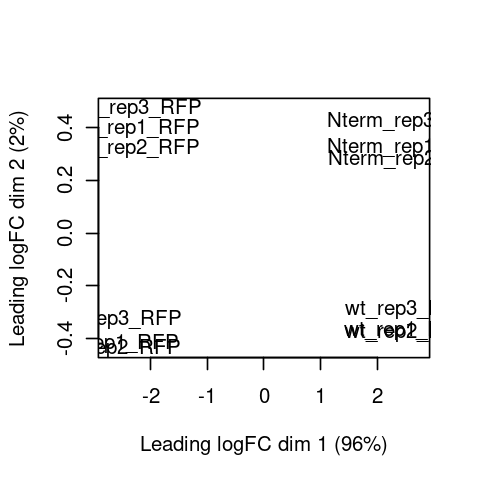

In [37]:
# plot MDS -- not very informative since of course the 1st PC is RNA vs RPF

lcpm_all = cpm(data_all, log=TRUE)
plotMDS(lcpm, labels=rownames(data_all$samples))

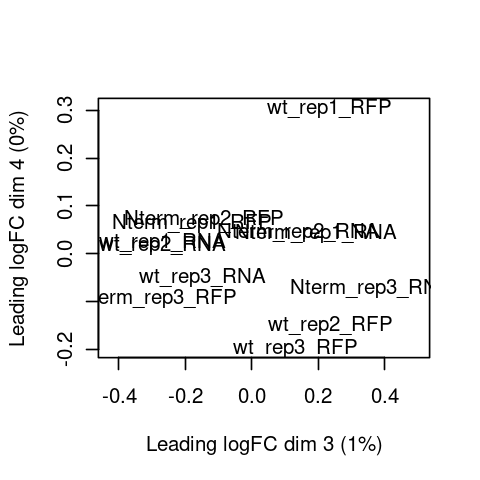

In [35]:
plotMDS(lcpm, labels=rownames(data_all$samples), dim.plot=c(3,4))

In [36]:
# displaying again for easy reference in constructing design_all matrix
data_all$samples

,group,lib.size,norm.factors,genotype,rep,RFP_or_RNA,grouping
,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<chr>
wt_rep1_RFP,wt_RFP,12907122,0.9942431,wt,1,RFP,wt_RFP
wt_rep2_RFP,wt_RFP,16042163,1.0266094,wt,2,RFP,wt_RFP
wt_rep3_RFP,wt_RFP,13712502,0.9896870,wt,3,RFP,wt_RFP
Nterm_rep1_RFP,Nterm_RFP,12447288,0.9946378,Nterm,1,RFP,Nterm_RFP
Nterm_rep2_RFP,Nterm_RFP,12898342,0.9874415,Nterm,2,RFP,Nterm_RFP
Nterm_rep3_RFP,Nterm_RFP,14914295,1.0079245,Nterm,3,RFP,Nterm_RFP
wt_rep1_RNA,wt_RNA,23475172,0.9937261,wt,1,RNA,wt_RNA
wt_rep3_RNA,wt_RNA,23565164,0.9995795,wt,3,RNA,wt_RNA
Nterm_rep2_RNA,Nterm_RNA,17849070,1.0050132,Nterm,2,RNA,Nterm_RNA


In [38]:
# our goal here is very similar to the example in the edgeR User's guide in section 3.5,
# 'Comparisons both between and within subjects'. The analogies are:
# Healthy/Disease1/Disease2 ~ S27>S27L, S27L>S27, and Unedited
# each patient ~ each replicate (note that in the example, they re-number their patients
# such that they have a patient #1, #2, and #3 in each disease)
# Treatment (hormone or none) (w/ a pair of treated/untreated samples for each patient) ~ RPF vs RNA 

# In the example they don't include the '0' so it's just ~Disease; I think it's more
# intuitive to include the 0 so it's explicitly clear what baseline is being subtracted
# however this only seems to solve this for the line variable, not lane or fraction...
# 

line = factor(data_all$samples$genotype, levels=c('wt', 'Nterm'))
fraction = factor(data_all$samples$RFP_or_RNA, levels=c('RNA', 'RFP'))

design_all = model.matrix(~0+line+fraction:line, data=data_all$samples)
colnames(design_all) = gsub(':', '_', colnames(design_all))
design_all

,linewt,lineNterm,linewt_fractionRFP,lineNterm_fractionRFP
wt_rep1_RFP,1,0,1,0
wt_rep2_RFP,1,0,1,0
wt_rep3_RFP,1,0,1,0
Nterm_rep1_RFP,0,1,0,1
Nterm_rep2_RFP,0,1,0,1
Nterm_rep3_RFP,0,1,0,1
wt_rep1_RNA,1,0,0,0
wt_rep3_RNA,1,0,0,0
Nterm_rep2_RNA,0,1,0,0
wt_rep2_RNA,1,0,0,0


In [80]:
# Trying a slightly different design?

line = factor(data_all$samples$genotype, levels=c('wt', 'Nterm'))
fraction = factor(data_all$samples$RFP_or_RNA, levels=c('RNA', 'RFP'))

design_all = model.matrix(~0+line:fraction, data=data_all$samples)
colnames(design_all) = gsub(':', '_', colnames(design_all))
design_all

,linewt_fractionRNA,lineNterm_fractionRNA,linewt_fractionRFP,lineNterm_fractionRFP
wt_rep1_RFP,0,0,1,0
wt_rep2_RFP,0,0,1,0
wt_rep3_RFP,0,0,1,0
Nterm_rep1_RFP,0,0,0,1
Nterm_rep2_RFP,0,0,0,1
Nterm_rep3_RFP,0,0,0,1
wt_rep1_RNA,1,0,0,0
wt_rep3_RNA,1,0,0,0
Nterm_rep2_RNA,0,1,0,0
wt_rep2_RNA,1,0,0,0


In [81]:
# and slightly different contrasts?
diff_te = makeContrasts(
    wt_TE_vs_Nterm_TE = (linewt_fractionRFP-linewt_fractionRNA) - (lineNterm_fractionRFP-lineNterm_fractionRNA),
                         levels=colnames(design_all))
diff_te

,wt_TE_vs_Nterm_TE
linewt_fractionRNA,-1
lineNterm_fractionRNA,1
linewt_fractionRFP,1
lineNterm_fractionRFP,-1


In [39]:
# make contrasts
diff_te = makeContrasts(lineNterm_fractionRFP-linewt_fractionRFP,
                        levels=colnames(design_all))

diff_te

,lineNterm_fractionRFP - linewt_fractionRFP
linewt,0
lineNterm,0
linewt_fractionRFP,-1
lineNterm_fractionRFP,1


,group,lib.size,norm.factors,genotype,rep,RFP_or_RNA,grouping
,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<chr>
wt_rep1_RFP,wt_RFP,12832817,0.9942431,wt,1,RFP,wt_RFP
wt_rep2_RFP,wt_RFP,16469036,1.0266094,wt,2,RFP,wt_RFP
wt_rep3_RFP,wt_RFP,13571085,0.9896870,wt,3,RFP,wt_RFP
Nterm_rep1_RFP,Nterm_RFP,12380543,0.9946378,Nterm,1,RFP,Nterm_RFP
Nterm_rep2_RFP,Nterm_RFP,12736358,0.9874415,Nterm,2,RFP,Nterm_RFP
Nterm_rep3_RFP,Nterm_RFP,15032483,1.0079245,Nterm,3,RFP,Nterm_RFP
wt_rep1_RNA,wt_RNA,23327891,0.9937261,wt,1,RNA,wt_RNA
wt_rep3_RNA,wt_RNA,23555255,0.9995795,wt,3,RNA,wt_RNA
Nterm_rep2_RNA,Nterm_RNA,17938551,1.0050132,Nterm,2,RNA,Nterm_RNA


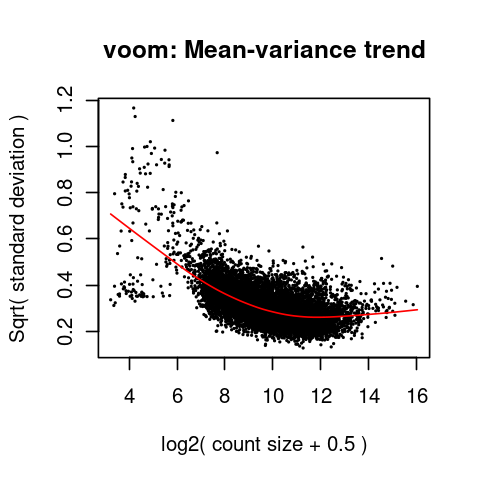

In [82]:
# perform voom

v_te = voom(data_all, design_all, plot=TRUE)
v_te


# note that the v_te$E matrix is pretty close to a log2(CPM + something)
# (online documentation calls this a 'normalized counts' matrix)
# I checked this by manually dividing the raw values in data_all$counts by data_all$samples$lib.size
# and taking log2 -- the results aren't identical to v_te$E but at least for the first 4x4 entries
# (which are all in the 2^5 to 2^8 range for CPM) they are within 0.01 (in log space)

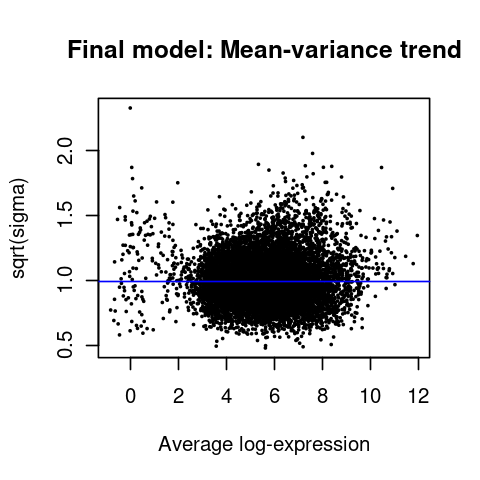

In [83]:
v_te_fit = lmFit(v_te, design_all)
v_te_fit = contrasts.fit(v_te_fit, contrasts=diff_te)
e_te_fit = eBayes(v_te_fit)
plotSA(e_te_fit, main="Final model: Mean-variance trend")

In [85]:
dt_te = decideTests(e_te_fit, p.value=0.1)
summary(dt_te)

       wt_TE_vs_Nterm_TE
Down                   2
NotSig             10869
Up                     3

In [86]:
head(e_te_fit)

,wt_TE_vs_Nterm_TE
CSMD3_ENST00000297405,-0.146724002
LRRC20_ENST00000446961,0.004272937
KCTD3_ENST00000259154,0.146018909
RBM5_ENST00000347869,0.164612978
UPF3A_ENST00000375299,-0.098871484
HLCS_ENST00000674895,-0.038957024
,wt_TE_vs_Nterm_TE
CSMD3_ENST00000297405,0.18251609
LRRC20_ENST00000446961,0.12911760
KCTD3_ENST00000259154,0.09418893


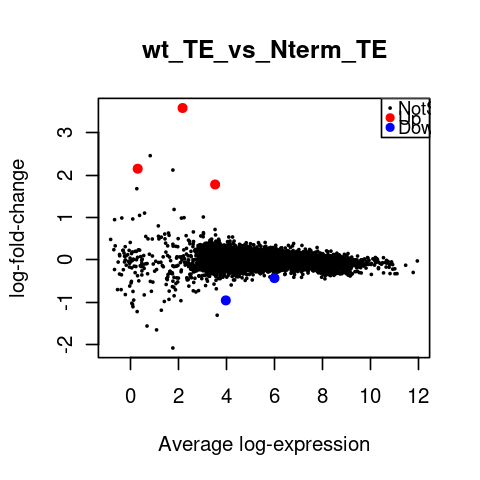

In [87]:
#output_file <- "wtRFP-NtermRFP_plotMD_output.pdf"
#pdf(output_file)
plotMD(e_te_fit, column=1, status=dt_te[,1], main=colnames(e_te_fit)[1])
#dev.off()

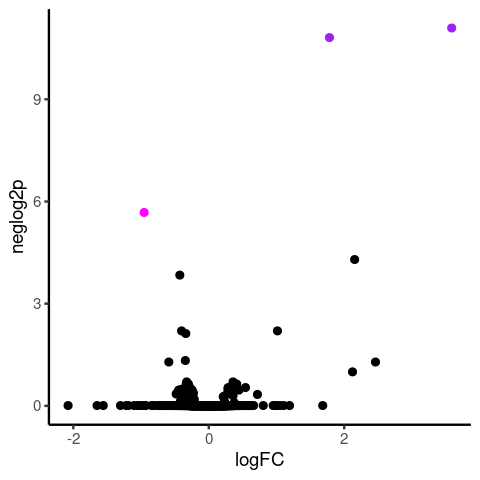

In [88]:
top_te_genes = topTable(e_te_fit, coef=1, number=sum(keep_all_cpm), sort.by='p')

library(ggplot2)

top_te_genes$neglog2p = -log(top_te_genes$adj.P.Val, 2)
top_te_genes$plot_fill = rep('black', nrow(top_te_genes))
top_te_genes[top_te_genes$logFC > 0.25 & top_te_genes$adj.P.Val < 0.05,'plot_fill'] = 'purple'
top_te_genes[top_te_genes$logFC < -0.25 & top_te_genes$adj.P.Val < 0.05,'plot_fill'] = 'magenta'

pal = c('black', 'magenta', 'purple')

top_te_genes$plot_fill = factor(top_te_genes$plot_fill, levels = pal)

options(repr.plot.width=4, repr.plot.height=4)

ggplot(data=top_te_genes, 
       aes(x=logFC, y=neglog2p, color=plot_fill)) + 
geom_point() + 
scale_color_manual(values=pal) + 
theme_classic() + 
theme(legend.position='none')

In [89]:
top_te_genes

,logFC,AveExpr,t,P.Value,adj.P.Val,B,neglog2p,plot_fill
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
PCDHB5_ENST00000231134,3.5868599,2.1562708,8.967732,4.209986e-08,0.0004577938,-0.8301436,11.0930143,purple
LLPH_ENST00000266604,1.7820172,3.5153053,8.447741,1.022396e-07,0.0005558766,1.4002313,10.8129478,purple
PCDHB9_ENST00000316105,-0.9540223,3.9618253,-6.336750,5.390690e-06,0.0195394539,1.8291582,5.6774660,magenta
H2AC20_ENST00000331380,2.1539685,0.2828848,5.732241,1.872190e-05,0.0508954779,-2.5281856,4.2963187,black
ELAPOR2_ENST00000450689,-0.4278168,5.9936775,-5.476377,3.215054e-05,0.0699209972,2.1836652,3.8381304,black
CSPG4_ENST00000308508,1.0142137,3.0229592,4.823869,1.319092e-04,0.2175610921,-0.8935333,2.2005075,black
RABAC1_ENST00000222008,-0.4012703,6.0707822,-4.796596,1.400522e-04,0.2175610921,0.9993367,2.2005075,black
RPS15A_ENST00000322989,-0.3389017,7.1772110,-4.711536,1.688876e-04,0.2295604807,0.9152609,2.1230538,black
RPL28_ENST00000344063,-0.3459635,8.2503410,-4.410469,3.290312e-04,0.3975428261,0.3620751,1.3308178,black


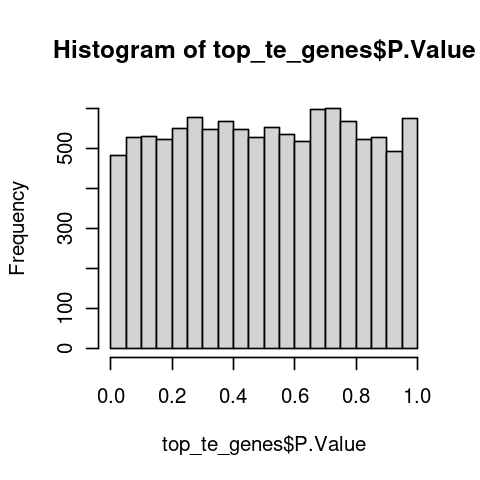

In [46]:
# check distribution of p-values
hist(top_te_genes$P.Value)

In [47]:
# check correlation between samples 
cor(v_te$E)

,wt_rep1_RFP,wt_rep2_RFP,wt_rep3_RFP,Nterm_rep1_RFP,Nterm_rep2_RFP,Nterm_rep3_RFP,wt_rep1_RNA,wt_rep3_RNA,Nterm_rep2_RNA,wt_rep2_RNA,Nterm_rep3_RNA,Nterm_rep1_RNA
wt_rep1_RFP,1.0000000,0.9932570,0.9933997,0.9851932,0.9872365,0.9817194,0.6558239,0.6526961,0.6439176,0.6558311,0.6330812,0.6434845
wt_rep2_RFP,0.9932570,1.0000000,0.9950423,0.9868172,0.9884125,0.9829139,0.6455154,0.6422758,0.6329016,0.6451164,0.6225640,0.6326663
wt_rep3_RFP,0.9933997,0.9950423,1.0000000,0.9902115,0.9917961,0.9880250,0.6662575,0.6645460,0.6564177,0.6658934,0.6483381,0.6567304
Nterm_rep1_RFP,0.9851932,0.9868172,0.9902115,1.0000000,0.9953156,0.9941034,0.6692250,0.6695805,0.6726922,0.6684097,0.6673884,0.6746682
Nterm_rep2_RFP,0.9872365,0.9884125,0.9917961,0.9953156,1.0000000,0.9936701,0.6691812,0.6689905,0.6711563,0.6688137,0.6642124,0.6715679
Nterm_rep3_RFP,0.9817194,0.9829139,0.9880250,0.9941034,0.9936701,1.0000000,0.6600866,0.6629406,0.6679911,0.6600263,0.6660579,0.6698315
wt_rep1_RNA,0.6558239,0.6455154,0.6662575,0.6692250,0.6691812,0.6600866,1.0000000,0.9958625,0.9866436,0.9972730,0.9773492,0.9857022
wt_rep3_RNA,0.6526961,0.6422758,0.6645460,0.6695805,0.6689905,0.6629406,0.9958625,1.0000000,0.9902258,0.9961124,0.9849304,0.9891734
Nterm_rep2_RNA,0.6439176,0.6329016,0.6564177,0.6726922,0.6711563,0.6679911,0.9866436,0.9902258,1.0000000,0.9871041,0.9930221,0.9959275
wt_rep2_RNA,0.6558311,0.6451164,0.6658934,0.6684097,0.6688137,0.6600263,0.9972730,0.9961124,0.9871041,1.0000000,0.9780861,0.9854269


In [48]:
# shortcut for finding the rowname corresponding to a gene
rownames(v_te$E)[grep('SNURF', rownames(v_te$E))]

character(0)

In [49]:
library(tidyr)
library(dplyr)
library(ggplot2)
library(repr)
options(repr.plot.width=4, repr.plot.height=4)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




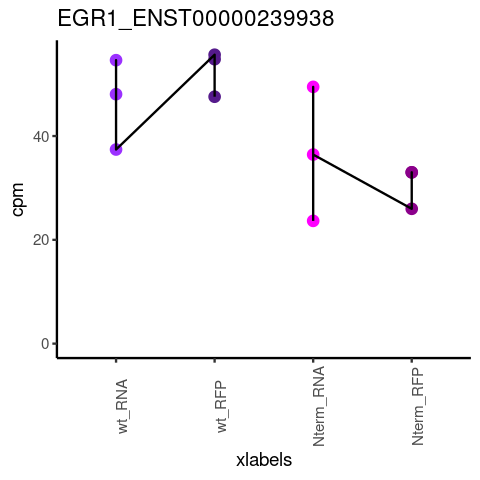

In [90]:
goi = 'EGR1_ENST00000239938'

#goi = 'LLPH_ENST00000266604'
norm_counts = 2^v_te$E[goi,]

palette = c('purple1', 'purple4', 'magenta', 'magenta4', 'gray50', 'gray20')

df = data.frame(sample = names(norm_counts), cpm = norm_counts)
df = separate(df, sample, c("genotype", "replicate", "fraction"))
df$lines = factor(df$genotype, levels=c('wt', 'Nterm'))
df$xlabels = factor(paste(df$genotype, df$fraction, sep="_"),
                    levels=c('wt_RNA',
                             'wt_RFP', 
                             'Nterm_RNA', 
                             'Nterm_RFP'))

p1 = ggplot(df, aes(x=xlabels, y=cpm))
p1 + geom_point(aes(color = xlabels), size=2.5) + geom_path(group=df$genotype) + ggtitle(goi) + theme_classic() + theme(legend.position = 'none', axis.text.x = element_text(angle = 90)) + expand_limits(y=0) + scale_color_manual(values = palette)
